<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: _______</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [1]:
from IPython.display import IFrame, display
#filepath = "Proyecto_2_EIE401.pdf"
#IFrame(filepath, width=700, height=400)

En la dirección https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ encontrarás el archivo batch_june2024.zip que contiene las imagenes que usarás para el procesamiento. ATENCION: usa el archivo zip indicado pues tienes las imagenes preparadas para tu trabajo.

## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 32x32 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.


In [ ]:
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict
from PIL import Image

# Función para leer una imagen en escala de grises
def leer_imagen_gris(ruta):
    imagen = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
    if imagen is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {ruta}")
    return imagen


# 2. Cargar imágenes desde ZIP sin convertir aún
zip_path = 'batch_june2024.zip'
images = []

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = [f for f in zip_ref.namelist() if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for file_name in file_list:
        with zip_ref.open(file_name) as file:
            img = Image.open(file).convert('RGB')  # Mantener color por ahora
            images.append((file_name, img))

# Cargar las plantillas desde el mismo directorio del script
plantilla_circ = leer_imagen_gris('circ_template.png')
plantilla_box = leer_imagen_gris('box_template.png')
plantilla_cross = leer_imagen_gris('cross_template.png')

## 2. Transformar imagen
Recuerda que la tarea es lograr el procesamiento más rápido posible.
Para lograr esto, realiza las operaciones que consideres necesarias sobre la imagen original para el posterior trabajo de Matching con las plantillas dadas. Crees que trabajar en el dominio de fourier o wavelet ayudaría en las etapas posteriores?

In [2]:
# Realiza un filtrado y binarización adaptativa a una imagen en escala de grises
def preparar_imagen(img):
    suavizada = cv2.bilateralFilter(img, d=1, sigmaColor=75, sigmaSpace=50)  # Suaviza bordes sin perder detalles
    umbralizada = cv2.adaptiveThreshold(
        suavizada,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=25,
        C=15
    )
    return umbralizada

## 3. Operaciones
Para extraer las caracteristicas, debes realizar las operaciones de segmentación, normalización o convolución como creas necesarias.
El resultado de tus operaciones vas a usarlo para el proceso de matching.


In [17]:
# Comparar una imagen con una plantilla mediante correlación cruzada normalizada
def correlacion_cruzada_normalizada(region, patron):
    resultado = cv2.matchTemplate(region, patron, cv2.TM_CCORR_NORMED)
    _, valor_maximo, _, posicion_max = cv2.minMaxLoc(resultado)
    return posicion_max, valor_maximo, resultado

In [15]:
# Secciona la imagen en sus cuatro regiones: superior izquierda, superior derecha, inferior derecha, inferior izquierda
def seccionar_en_cuartos(imagen):
    h, w = imagen.shape[:2]
    h_m, w_m = h // 2, w // 2

    regiones = {
        "sup_izq": imagen[0:h_m, 0:w_m],
        "sup_der": imagen[0:h_m, w_m:],
        "inf_der": imagen[h_m:, w_m:],
        "inf_izq": imagen[h_m:, 0:w_m]
    }
    return regiones

# Gira una imagen en sentido horario o antihorario según el ángulo dado (90, 180, 270)
def girar_imagen(plantilla, grados):
    if grados == 90:
        return cv2.rotate(plantilla, cv2.ROTATE_90_CLOCKWISE)
    elif grados == 180:
        return cv2.rotate(plantilla, cv2.ROTATE_180)
    elif grados == 270:
        return cv2.rotate(plantilla, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        return plantilla

In [14]:
# Función para transformar la imagen a escala de grises con suavizado
def transformar_imagen_en_grises(imagen_rgb):
    imagen_gray = cv2.cvtColor(imagen_rgb, cv2.COLOR_RGB2GRAY)

    return imagen_gray

# Lista de imágenes tipo (nombre_archivo, imagen_PIL) que tú ya tienes
# Ejemplo: images = [("img1.jpg", Image.open("ruta/a/img1.jpg")), ...]

imagenes_preprocesadas = []

# Procesar las imágenes
for nombre, imagen_pil in images:
    imagen_np = np.array(imagen_pil)  # Convertir a NumPy array
    imagen_proc = transformar_imagen_en_grises(imagen_np)
    imagenes_preprocesadas.append((nombre, imagen_proc))

# Crear carpeta de salida si no existe
os.makedirs('imagenes2', exist_ok=True)

# Guardar las imágenes procesadas
for nombre, imagen_proc in imagenes_preprocesadas:
    nombre_base = os.path.basename(nombre)
    ruta_salida = os.path.join('imagenes2', nombre_base)
    Image.fromarray(imagen_proc).save(ruta_salida)

## 4. Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación

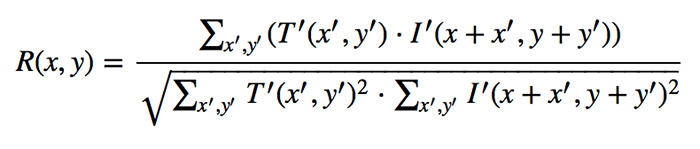

Este proceso es similar a un windowing, donde la ventana es la imagen de referencia. 
Como verás es un proceso iterativo, dispendioso, pero en el que puedes poner tu creatividad a funcionar para lograrlo de forma eficiente.

#### _TIP: realiza el proceso un batch pequeño de imagenes, o solo sobre un par de ellas, hasta que estés satisfecho con el resultado. Una vez esté listo, ESCALA el procedimiento para operar todas la imagenes lo más rápido posible.!_

In [30]:
ruta_carpeta = 'imagenes2'  # Verifica que esta ruta exista, si no cambia a 'processed 512'
registros = []

matriz_confusion = {
    "box": {"box": 0, "circ": 0, "cross": 0},
    "circ": {"box": 0, "circ": 0, "cross": 0},
    "cross": {"box": 0, "circ": 0, "cross": 0}
}

inicio = time.time()

for archivo in os.listdir(ruta_carpeta):
    if archivo.lower().endswith(('.png', '.jpg')):
        ruta_img = os.path.join(ruta_carpeta, archivo)
        imagen = cv2.imread(ruta_img, cv2.IMREAD_UNCHANGED) 

        partes = archivo.split('_')
        if len(partes) < 3:
            print(f"Nombre de archivo inesperado, se omite: {archivo}")
            continue

        clase_real = partes[0]
        identificador = partes[2]

        zonas = seccionar_en_cuartos(imagen)

        zonas_preproc = {nombre: preparar_imagen(cuadro) for nombre, cuadro in zonas.items()}
        temp_circ_proc = preparar_imagen(plantilla_circ)
        temp_box_proc = preparar_imagen(plantilla_box)
        temp_cross_proc = preparar_imagen(plantilla_cross)

        giros_por_zona = {
            "sup_izq": 0,
            "sup_der": 90,
            "inf_der": 180,
            "inf_izq": 270
        }

        suma_circ = 0
        suma_box = 0
        suma_cross = 0
        total_zonas = 0

        for nombre_zona, imagen_zona in zonas_preproc.items():
            ang = giros_por_zona.get(nombre_zona, 0)  # Por si hay zona no esperada

            circ_rot = girar_imagen(temp_circ_proc, ang)
            box_rot = girar_imagen(temp_box_proc, ang)
            cross_rot = girar_imagen(temp_cross_proc, ang)

            _, val_circ, _ = correlacion_cruzada_normalizada(imagen_zona, circ_rot)
            _, val_box, _ = correlacion_cruzada_normalizada(imagen_zona, box_rot)
            _, val_cross, _ = correlacion_cruzada_normalizada(imagen_zona, cross_rot)

            suma_circ += val_circ
            suma_box += val_box
            suma_cross += val_cross
            total_zonas += 1

        prom_circ = suma_circ / total_zonas if total_zonas else 0
        prom_box = suma_box / total_zonas if total_zonas else 0
        prom_cross = suma_cross / total_zonas if total_zonas else 0

        if prom_circ > prom_box and prom_circ > prom_cross:
            clase_predicha = "circ"
        elif prom_box > prom_circ and prom_box > prom_cross:
            clase_predicha = "box"
        else:
            clase_predicha = "cross"

        registros.append({
            "Archivo": archivo,
            "Etiqueta Real": clase_real,
            "ID": identificador,
            "Promedio NCC - Círculo": prom_circ,
            "Promedio NCC - Cuadro": prom_box,
            "Promedio NCC - Cruz": prom_cross,
            "Resultado": clase_predicha
        })

        matriz_confusion[clase_real][clase_predicha] += 1

fin = time.time()
print(f"Tiempo total de ejecución: {fin - inicio:.2f} segundos")



Tiempo total de ejecución: 113.88 segundos


# 5. Clasificación
De cada operación realizada de matching, obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.

Presenta aquí el resultado de clasificación numérico, así como  dos ejemplos verdaderos y dos ejemplos falsos de imagenes clasificadas.


In [31]:
labels = list(matriz_confusion.keys())
values = np.array([[matriz_confusion[label][pred] for pred in matriz_confusion[label]] for label in labels])

# Imprimir encabezado con etiquetas predichas
print(f"{'Real \\ Pred':>10}", end=" ")
for pred in labels:
    print(f"{pred:>6}", end=" ")
print()

# Imprimir filas con etiqueta real y valores de predicción
for i, real in enumerate(labels):
    print(f"{real:>10}", end=" ")
    for j in range(len(labels)):
        print(f"{values[i, j]:6d}", end=" ")
    print()

# También puedes calcular y mostrar la tasa de error global (opcional)
total = values.sum()
correctos = np.trace(values)
error_rate = 100 * (1 - correctos / total)
print(f"\nError de clasificación global: {error_rate:.2f}%")

Real \ Pred    box   circ  cross 
       box   3700    289      0 
      circ      0   4416      0 
     cross    452     78   5393 

Error de clasificación global: 5.72%


In [36]:
# Agrupar ejemplos correctos e incorrectos por clase real
correctos_por_clase = defaultdict(list)
incorrectos_por_clase = defaultdict(list)

for r in registros:
    if r["Etiqueta Real"] == r["Resultado"]:
        correctos_por_clase[r["Etiqueta Real"]].append(r)
    else:
        incorrectos_por_clase[r["Etiqueta Real"]].append(r)

total_registros = len(registros)
total_incorrectos = sum(len(incorrectos_por_clase[c]) for c in incorrectos_por_clase)
porcentaje_error = 100 * total_incorrectos / total_registros if total_registros else 0
print(f"Error de clasificación global: {porcentaje_error:.2f}%\n")

# Porcentaje de error por clase
for clase in ["box", "circ", "cross"]:
    total_clase = len(correctos_por_clase.get(clase, [])) + len(incorrectos_por_clase.get(clase, []))
    incorrectos_clase = len(incorrectos_por_clase.get(clase, []))
    porcentaje_error_clase = 100 * incorrectos_clase / total_clase if total_clase else 0
    print(f"Error de clasificación para la clase '{clase}': {porcentaje_error_clase:.2f}%")

print("\nEjemplos correctos:")
for clase in ["box", "circ", "cross"]:
    ejemplos = correctos_por_clase.get(clase, [])
    for r in ejemplos[:2]:  # hasta 2 ejemplos por clase
        print(f"Clase real: {r['Etiqueta Real']} - Clase inferida: {r['Resultado']}")

print("\nEjemplos incorrectos:")
for clase in ["box", "circ", "cross"]:
    ejemplos = incorrectos_por_clase.get(clase, [])
    for r in ejemplos[:2]:  # hasta 2 ejemplos por clase
        print(f"Clase real: {r['Etiqueta Real']} - Clase inferida: {r['Resultado']}")


Error de clasificación global: 5.72%

Error de clasificación para la clase 'box': 7.24%
Error de clasificación para la clase 'circ': 0.00%
Error de clasificación para la clase 'cross': 8.95%

Ejemplos correctos:
Clase real: box - Clase inferida: box
Clase real: box - Clase inferida: box
Clase real: circ - Clase inferida: circ
Clase real: circ - Clase inferida: circ
Clase real: cross - Clase inferida: cross
Clase real: cross - Clase inferida: cross

Ejemplos incorrectos:
Clase real: box - Clase inferida: circ
Clase real: box - Clase inferida: circ
Clase real: cross - Clase inferida: box
Clase real: cross - Clase inferida: box


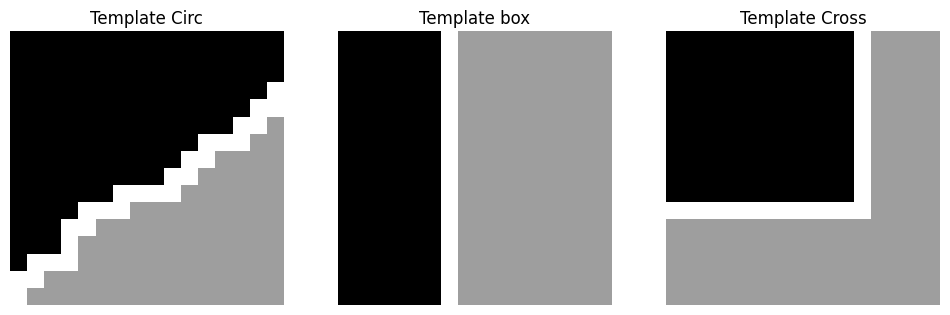

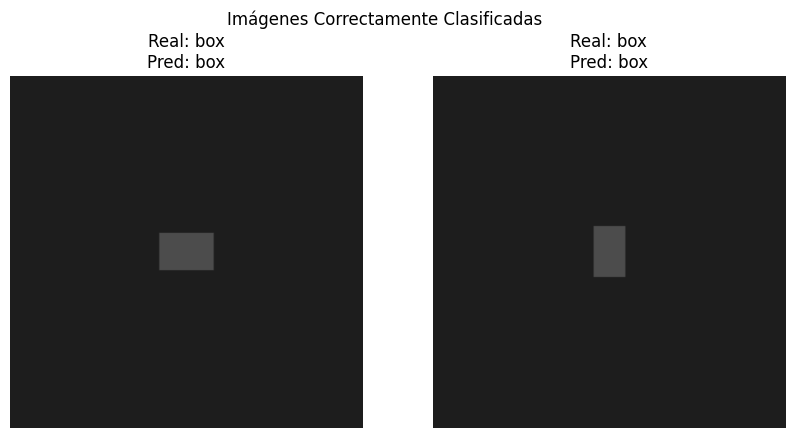

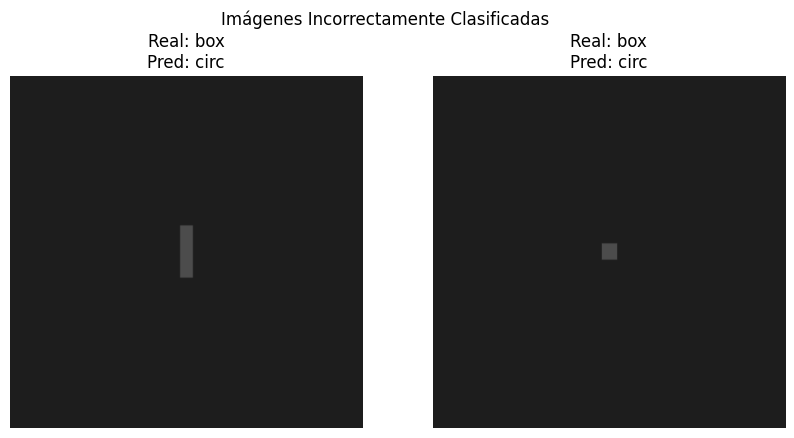

In [38]:
# Mostrar templates
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(plantilla_circ, cmap='gray')
axs[0].set_title("Template Circ")
axs[0].axis('off')

axs[1].imshow(plantilla_box, cmap='gray')
axs[1].set_title("Template box")
axs[1].axis('off')

axs[2].imshow(plantilla_cross, cmap='gray')
axs[2].set_title("Template Cross")
axs[2].axis('off')
plt.show()
# Variables que deben estar definidas: registros, ruta_carpeta

correctos = []
incorrectos = []

for registro in registros:
    if registro["Etiqueta Real"] == registro["Resultado"]:
        if len(correctos) < 2:
            correctos.append(registro)
    else:
        if len(incorrectos) < 2:
            incorrectos.append(registro)
    if len(correctos) == 2 and len(incorrectos) == 2:
        break

def mostrar_imagenes(lista_registros, titulo):
    plt.figure(figsize=(10, 5))
    for i, reg in enumerate(lista_registros):
        ruta_img = os.path.join(ruta_carpeta, reg["Archivo"])
        img = cv2.imread(ruta_img)
        if img is None:
            print(f"No se pudo cargar la imagen: {reg['Archivo']}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir a RGB para matplotlib
        plt.subplot(1, len(lista_registros), i + 1)
        plt.imshow(img)
        plt.title(f"Real: {reg['Etiqueta Real']}\nPred: {reg['Resultado']}")
        plt.axis('off')
    plt.suptitle(titulo)
    plt.show()

mostrar_imagenes(correctos, "Imágenes Correctamente Clasificadas")
mostrar_imagenes(incorrectos, "Imágenes Incorrectamente Clasificadas")

# 6. Medición
Recuerda que debes imprimir el tiempo que tarda tu algoritmo en procesar todas las imagenes en la base de datos. Usa el siguiente fragmento de código, ubicando el inicio y fin donde corresponda.





In [37]:
print(f"Tiempo total de ejecución: {fin - inicio:.2f} segundos")

tiempo_segundos = fin - inicio
minutos = int(tiempo_segundos // 60)
segundos = tiempo_segundos % 60

print(f"Tiempo total de ejecución: {minutos} minutos y {segundos:.2f} segundos")


Tiempo total de ejecución: 113.88 segundos
Tiempo total de ejecución: 1 minutos y 53.88 segundos
